<AxesSubplot:>

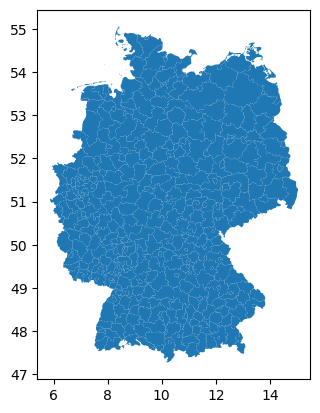

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
os.chdir("/home/reffert/DeepAR_InfluenzaForecast")
import geopandas as gpd
import collections
from PythonFiles.model import model,preprocessing
from PythonFiles.Configuration import Configuration
import warnings
warnings.filterwarnings("ignore")
config = Configuration()
influenza_df = pd.read_csv("/home/reffert/DeepAR_InfluenzaForecast/Notebooks/DataProcessing/influenza.csv", sep=",")
df = gpd.read_file("/home/reffert/DeepAR_InfluenzaForecast/Notebooks/DataProcessing/vg2500_krs.shp")
df = df.set_geometry("geometry")  
df.plot()

## Match the names in Influenza.csv to the names in the Shapefile

In [2]:
renaming_dict = dict()
# Iterate over the names defined by the Shapefile
for name in df.GEN.unique():
    renaming_dict[name] = []
    # then iterate over the locations names defined by the influenza.csv file
    for location in influenza_df.location.unique():
        # filter out the names, where the Shapefile-Name String is part of the Influenza-File-Name String, and save them to the dict
        if name in location:
            renaming_dict[name].append(location) 
    # overwrite some locations with manually defined matches
    if name in config.specific_matches.keys():
        renaming_dict[name] = config.specific_matches[name]
        
# save the entries of the renaming dict where we have no match or at least 2 matches
not_matching_dict = {k:v for k, v in zip(renaming_dict.keys(), renaming_dict.values()) if ((len(v)==0) | (len(v)>1))}
# also save the entries where we have exactly one match (as it's supposed to be)
correctly_matched_dict = {k:v for k, v in zip(renaming_dict.keys(), renaming_dict.values()) if len(v) == 1}

#remaining_loc = [location for location in locations if location not in [location[0] for location in correctly_matched_dict.values()]]
not_renamed_shapefile_locations = []

# Create the correct location column in the df
for name in renaming_dict.keys():
    # select not correctly matched locations 
    if name in not_matching_dict.keys():
        # select a subset containing the not correctly matched region 
        unmatched_df = df[df.GEN == name].copy()
        # locations with double entries "lK" and "SK" are correctly selected by their shape length
        if len(unmatched_df) > 1:
            unmatched_df.loc[unmatched_df["SHAPE_LENG"] == min(unmatched_df["SHAPE_LENG"]),"location"] = f"SK {name}"
            unmatched_df.loc[unmatched_df["SHAPE_LENG"] == max(unmatched_df["SHAPE_LENG"]),"location"] = f"LK {name}"
        # the remaining uncorrectly matched locations are given the Shapefile name and won't be considered further on [not_renamed_shapefile_locations]
        if len(unmatched_df) == 1:
            unmatched_df.loc[:,"location"] = f"{name}"
            not_renamed_shapefile_locations.append(name)
        # then the location column is inherited by the original df
        df.loc[df.GEN == name,"location"] = unmatched_df["location"]
    #select the names where we already have a correct match
    elif name in correctly_matched_dict.keys():
        df.loc[df["GEN"] == name,"location"] = correctly_matched_dict[name][0]
# Print out a message if there are still 
if df["location"].isna().any() == True:
    print(f"THE DF contains nan locations.{df[df['location'].isna() == True]}")

### Discrepancies between the Shapefile and the Influenza.csv -> Handling Berlin areas

In [3]:
not_implemented_influenza_locations = [location for location in influenza_df.location.unique() if location not in df.location.unique()]    
print("The following influenza locations aren't implemented yet, as they found not match within the shapefile locations:\n")
print(not_implemented_influenza_locations, "\n")
print("The following Shapefile locations remained unchanged, as they found no match within the influenza locations:\n")
print(not_renamed_shapefile_locations)

The following influenza locations aren't implemented yet, as they found not match within the shapefile locations:

['SK Berlin Charlottenburg-Wilmersdorf', 'SK Berlin Friedrichshain-Kreuzberg', 'SK Berlin Lichtenberg', 'SK Berlin Marzahn-Hellersdorf', 'SK Berlin Mitte', 'SK Berlin Neukölln', 'SK Berlin Pankow', 'SK Berlin Reinickendorf', 'SK Berlin Spandau', 'SK Berlin Steglitz-Zehlendorf', 'SK Berlin Tempelhof-Schöneberg', 'SK Berlin Treptow-Köpenick'] 

The following Shapefile locations remained unchanged, as they found no match within the influenza locations:

['Osterode am Harz', 'Berlin', 'Eisenach']


In [4]:
matrix_df = pd.DataFrame(columns=config.berlin_neighbors.keys(), index=config.berlin_neighbors.keys())
for key in config.berlin_neighbors.keys():
    neighbors = config.berlin_neighbors[key]
    if len(neighbors) > 0:
        for neighbor in neighbors:
            matrix_df.loc[key, neighbor] = 1
            matrix_df.loc[neighbor, key] = 1
            matrix_df.loc[key, key] = 0
    else:
        print(key)
matrix_df = matrix_df.fillna(0)
display(matrix_df)

,SK Berlin Charlottenburg-Wilmersdorf,SK Berlin Friedrichshain-Kreuzberg,SK Berlin Lichtenberg,SK Berlin Marzahn-Hellersdorf,SK Berlin Mitte,SK Berlin Neukölln,SK Berlin Pankow,SK Berlin Reinickendorf,SK Berlin Spandau,SK Berlin Steglitz-Zehlendorf,...,LK Oberspreewald-Lausitz,LK Spree-Neiße,SK Brandenburg a.d.Havel,LK Ostprignitz-Ruppin,LK Jerichower Land,LK Stendal,SK Frankfurt (Oder),LK Mecklenburgische Seenplatte,LK Anhalt-Bitterfeld,LK Wittenberg
SK Berlin Charlottenburg-Wilmersdorf,0,0,0,0,1,0,0,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SK Berlin Friedrichshain-Kreuzberg,0,0,1,0,1,1,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SK Berlin Lichtenberg,0,1,0,1,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SK Berlin Marzahn-Hellersdorf,0,0,1,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SK Berlin Mitte,1,1,0,0,0,0,1,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SK Berlin Neukölln,0,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SK Berlin Pankow,0,1,1,0,1,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SK Berlin Reinickendorf,1,0,0,0,1,0,1,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SK Berlin Spandau,1,0,0,0,0,0,0,1,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SK Berlin Steglitz-Zehlendorf,1,0,0,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Determine the neighbors based on the Shapefile with the correctly implemented influenza names

In [5]:
df["my_neighbors"] = ""
for index, row in df.iterrows():  
    # determine the nieghboring regions and select their location name
    neighbors = list(df[(df.geometry.touches(row["geometry"])) | (df.geometry.overlaps(row["geometry"]))].location)
    # remove the location itself, if it's within the determined neighbors
    if row.location in neighbors:   
        neighbors = neighbors.remove(row.location) 
    if neighbors is not None:
        df.at[index, "my_neighbors"] = neighbors
df["my_neighbors"] = df["my_neighbors"].fillna("nan")

df.to_csv("/home/reffert/DeepAR_InfluenzaForecast/Notebooks/DataProcessing/GeoDf.csv")

### To check correctness: Plot of the location and it's neighbors

[['SK Kaiserslautern', 'SK Landau i.d.Pfalz', 'SK Neustadt a.d.Weinstraße', 'SK Worms', 'LK Alzey-Worms', 'LK Donnersbergkreis', 'LK Kaiserslautern', 'LK Südliche Weinstraße', 'LK Rhein-Pfalz-Kreis', 'LK Südwestpfalz']]
['SK Kaiserslautern', 'SK Landau i.d.Pfalz', 'SK Neustadt a.d.Weinstraße', 'SK Worms', 'LK Alzey-Worms', 'LK Donnersbergkreis', 'LK Kaiserslautern', 'LK Südliche Weinstraße', 'LK Rhein-Pfalz-Kreis', 'LK Südwestpfalz']


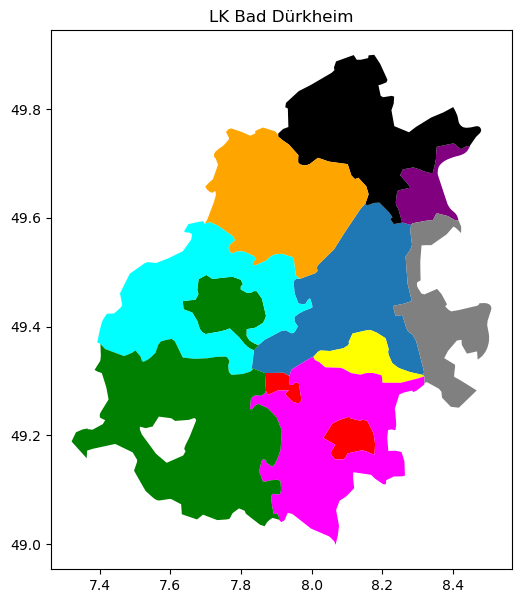

In [9]:
colors = ["green", "red", "yellow" , "purple", "black", "orange", "cyan", "magenta", "grey"]*2
selection = ["LK Bad Dürkheim"]
for location in selection:
    location_df = df.loc[df.location == location].copy()
    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    location_df.plot(ax=ax)
    plt.title(f"{location}")
    neighbors = list(location_df["my_neighbors"])
    print(neighbors)
    if len(neighbors) > 0:
        for neighbor in neighbors:
            neighbor_df = df.loc[df.location.isin(list(neighbor))].copy()
            neighbor_df.plot(neighbor_df, ax=ax, color=colors, legend=True)
plt.show()

## Creation of the AdjacencyMatrix

In [7]:
# Creation of the matrix dataframe, which will later be exported as the AdjacencyMatrix
matrix_df = pd.DataFrame(columns=influenza_df.location.unique(), index=influenza_df.location.unique())
# Iterate over all available location names in the influenza data
for location in influenza_df.location.unique():
    # handle the berlin districts seperately, as they aren't split up correctly in the Shapefile
    if location in config.berlin_neighbors.keys():
        neighbors = config.berlin_neighbors[location]
    else:
        location_df = df.loc[df.location == location].copy()
        neighbors = list(location_df["my_neighbors"])[0]
        if len(neighbors) <= 0:
            print(f"{location} doesn't have any neighbors...")
    # iterate over the previously determined neighbors and select the correct matrix places for 1's
    for neighbor in neighbors:
        if neighbor not in not_renamed_shapefile_locations:
            matrix_df.loc[location, neighbor] = 1
            matrix_df.loc[neighbor, location] = 1
            matrix_df.loc[location, location] = 0
matrix_df = matrix_df.fillna(0)

In [8]:
# check for correct nieghbors of some locations
selection = ["LK Northeim", "LK Alzey-Worms"]
for s in selection:
    print(s)
    print(matrix_df.loc[matrix_df[s] == 1,s],"\n")

LK Northeim
LK Goslar        1
LK Göttingen     1
LK Hildesheim    1
LK Holzminden    1
LK Höxter        1
LK Kassel        1
Name: LK Northeim, dtype: int64 

LK Alzey-Worms
LK Bad Dürkheim        1
LK Bad Kreuznach       1
LK Bergstraße          1
LK Donnersbergkreis    1
LK Groß-Gerau          1
LK Mainz-Bingen        1
SK Worms               1
Name: LK Alzey-Worms, dtype: int64 



In [9]:
matrix_df.to_csv("/home/reffert/DeepAR_InfluenzaForecast/Notebooks/DataProcessing/AdjacentMatrix.csv")